# Import Packages

In [1]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 40.7 MB/s eta 0:00:00


In [16]:
import pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, spraychart, statcast_sprint_speed, statcast_running_splits
from pybaseball.plotting import plot_bb_profile

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime

# Import, Transform Data

In [3]:
start_date = '2022-04-01'
end_date = '2022-10-03'
#end_date = '2022-05-03'

data = statcast(start_date, end_date)
sprint_data22 = statcast_running_splits(2022, 1, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 1)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 186/186 [05:31<00:00,  1.78s/it]


In [4]:
hit_vars = ['events','game_date','home_team','batter','bb_type', 'des', "launch_speed", "launch_angle",'hc_x', 'hc_y','hit_distance_sc']

# Limit variables, and runners who do not have sprint speed data
data = data[hit_vars]
data = data[data['batter'].isin(speed_data22['player_id'].unique())]
data = data.dropna()

# Handle the launch_speed, launch_angle, hc_x, hc_y, hit_distance_sc na values

hits = ['triple','single','double','home_run']

hits = data[data['events'].isin(hits)]

season_start = datetime.strptime(start_date, '%Y-%m-%d').date()
hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)

hits = hits.rename(columns = {'game_date':'game_week'})

# Takes negative arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
hits['angle'] = (-1*np.arctan((hits.hc_x - 130)/(210 - hits.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
hits['r'] = np.hypot((210 - hits.hc_y),(hits.hc_x - 130))

# taking all home runs, average over the proportion of projected distance to r value
r_value_multiplier = np.mean(hits[hits.events == 'home_run']['hit_distance_sc'] / hits[hits.events == 'home_run']['r'])

# Scale up all values by r-value scalar to get better measure of total distance traveled
hits['calc_distance'] = round(hits['r'] * r_value_multiplier,0)
hits = hits.drop(['hc_x','hc_y'], axis = 1)
hits = hits[hits['events'] != 'home_run']


hits = hits.rename(columns = {'batter':'player_id', 'hit_distance_sc': 'contact_distance'})
hits = hits[~hits['des'].str.contains('fielding error')]

hits['sprint_speed'] = hits.apply(lambda x: np.random.normal(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0], np.std(np.arange(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] - 1, speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] + 1, 0.05)), 1)[0], axis = 1)

hits = hits.drop(['des','player_id','r'], axis = 1)
hits = hits[['events','game_week','home_team','launch_speed','launch_angle','angle','contact_distance', 'calc_distance','sprint_speed']]

hits['distance'] = hits[['calc_distance', 'contact_distance']].max(axis=1)
hits = hits.drop(['calc_distance', 'contact_distance'], axis = 1)
hits = hits[['events','game_week','home_team','launch_speed','launch_angle','angle','distance','sprint_speed']]

hits

<ipython-input-4-6251fd6ba419>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)


,events,game_week,home_team,launch_speed,launch_angle,angle,distance,sprint_speed
3096,triple,26,BOS,105.9,13,1.386628,322.0,26.712246
461,single,26,BOS,105.7,20,1.920752,371.0,27.314510
818,single,26,BOS,92.3,0,1.928362,227.0,26.878066
1159,double,26,BOS,78.5,25,0.83157,292.0,25.197254
2804,single,26,BOS,105.9,15,1.347517,319.0,27.583900
...,...,...,...,...,...,...,...,...
1104,single,0,PIT,101.6,13,1.679537,238.0,24.345477
1846,single,0,STL,105.0,12,1.06231,220.0,27.134877
2438,single,0,STL,61.9,-69,2.279882,88.0,25.854910
2689,single,0,STL,99.1,3,1.558905,158.0,26.905325


In [5]:
X = hits.drop('events', axis=1)
y = hits.events

# Define the label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Model Instantiation, Comparison

## Helper Funtions

In [11]:
# Creates cheat-sheet of  pitches and corresponding value after being encoded
outcomes = pd.DataFrame()
outcomes['Hit Type'] = label_encoder.inverse_transform(list(set(y)))
outcomes['Encoded'] = list(set(y))

print(outcomes)

  Hit Type  Encoded
0   double        0
1   single        1
2   triple        2


In [12]:
def plot_probability_histograms(model_name, predicted_probabilities, axis, row):
  """
  Plots array of predicted probabilities for test/validation data on each class

  Parameters:
  -----------
  model_name : str
      Name of model, used for formatting
  predicted_probabilities : NumPy Array
      Array of predicited probabilities, each column will be plotted in histogram,
      each column represents probabiltiies for each unique class
  axis : Matplotlib axis
      Specific axis of matplotlib figure the histogram will be plotted
  row : int
      Row of defined matplotlib figure for each model

  Returns:
  --------
  None
  """
  num_classes = predicted_probabilities.shape[1]
  colors = plt.cm.rainbow(np.linspace(0, 1, 3))

  # Iterate over each class
  for m in range(num_classes):
    class_probs = predicted_probabilities[:, m]

    # Plot histogram
    axis[row, m].hist(class_probs, bins=100, range=(0.0, 1.0), edgecolor='black', alpha=0.7, color=colors[m])
    axis[row, m].set_xlabel('Probability')
    axis[row, m].set_ylabel('Frequency')
    axis[row, m].set_title(f'Probability Distribution: {label_encoder.inverse_transform([m])[0]}s, {model_name}')

In [13]:
def plot_confusion_matrix(conf_mat, axis, name, class_li):
  """
  Plot sk-learn confusion matrix in matplotlib

  Takes conf_matrix, plots in specific axis depending on model,
  adds correct formatting and style

  Parameters:
  -----------
  conf_mat : Sklearn Confusion Matrix (np.array)
      Confusion matrix that will be plotted in matplotlib
  axis : Matplotlib axis
      Specific column of matplotlib figure the confusion matrix is plotted
  name : str
      Name of model, used for formatting
  class_li : list
      List of unique classes being plotted in Confusion Matrix

  Returns:
  --------
  None
  """

  # Initialize formatting
  im = axis.imshow(conf_mat, cmap=plt.cm.coolwarm)
  axis.set_title(name)
  axis.set_xlabel('Predicted Labels')
  axis.set_ylabel('True Labels')
  axis.set_xticks(np.arange(len(class_li)))
  axis.set_yticks(np.arange(len(class_li)))
  axis.set_xticklabels(class_li)
  axis.set_yticklabels(class_li)
  plt.setp(axis.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  # Display values in each cell of the confusion matrix
  for i in range(len(class_li)):
      for j in range(len(class_li)):
          axis.text(j, i, conf_mat[i, j], ha="center", va="center", color="white")

In [14]:
def plot_rocauc_pr_rec(model_name, ax_roc, ax_pr, y_true,y_pred_proba, class_li):
  """
  Plot ROC-AUC and Precision Recall curves for each class

  Takes true y-values, classifiers predicted probabilities for all classes,
  plots calculated ROC-AUC and Precision-Recall

  Parameters:
  -----------
  model_name : str
      Name of model, used for formatting
  ax_roc : Matplotlib subplot
      Specific subplot of matplotlib figure the ROC-AUC will be plotted
  ax_pr : Matplotlib subplot
      Specific subplot of matplotlib figure the Precision-Recall will be plotted
  y_true : NumPy Array
      Array of true y-values, used for calculating ROC-AUC and Precision-Recall
  y_pred_proba : NumPy Array
      Array of y predicited probabilities, used for calculating ROC-AUC and Precision-Recall
  class_li : list
      List of unique classes
  Returns:
  --------
  None
  """
  # Plot ROC-AUC multiclass, each classifier
  for m in range(len(class_li)):
      class_name = label_encoder.inverse_transform([m])[0]

      # Calculates ROC-AUC, plots curve
      fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, m], pos_label=m)
      roc_auc = auc(fpr, tpr)
      ax_rocauc.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(class_name, roc_auc))

      # Calculates and Plots Precision and Recall
      precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, m], pos_label=m)
      ax_pr.plot(recall, precision, lw=2, label='Class {}'.format(class_name))

  # Formatting ROC-AUC
  ax_roc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random')
  ax_roc.set_xlim([-0.05, 1.05])
  ax_roc.set_ylim([-0.05, 1.05])
  ax_roc.set_xlabel('False Positive Rate')
  ax_roc.set_ylabel('True Positive Rate')
  ax_roc.set_title('ROC-AUC Curve - {}'.format(model_name))
  ax_roc.legend(loc="lower right")

  # Formatting Precision-Recall
  ax_pr.set_xlim([-0.05, 1.05])
  ax_pr.set_ylim([-0.05, 1.05])
  ax_pr.set_xlabel('Recall')
  ax_pr.set_ylabel('Precision')
  ax_pr.set_title('Precision-Recall Curve - {}'.format(model_name))
  ax_pr.legend(loc="lower left")

## Building Models

Evaluating... Naive Bayes


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... SVC


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... Bagged Decision Trees


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... AdaBoost Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... Probabilistic Neural Net


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


266/266 [==============================] - 0s 1ms/step


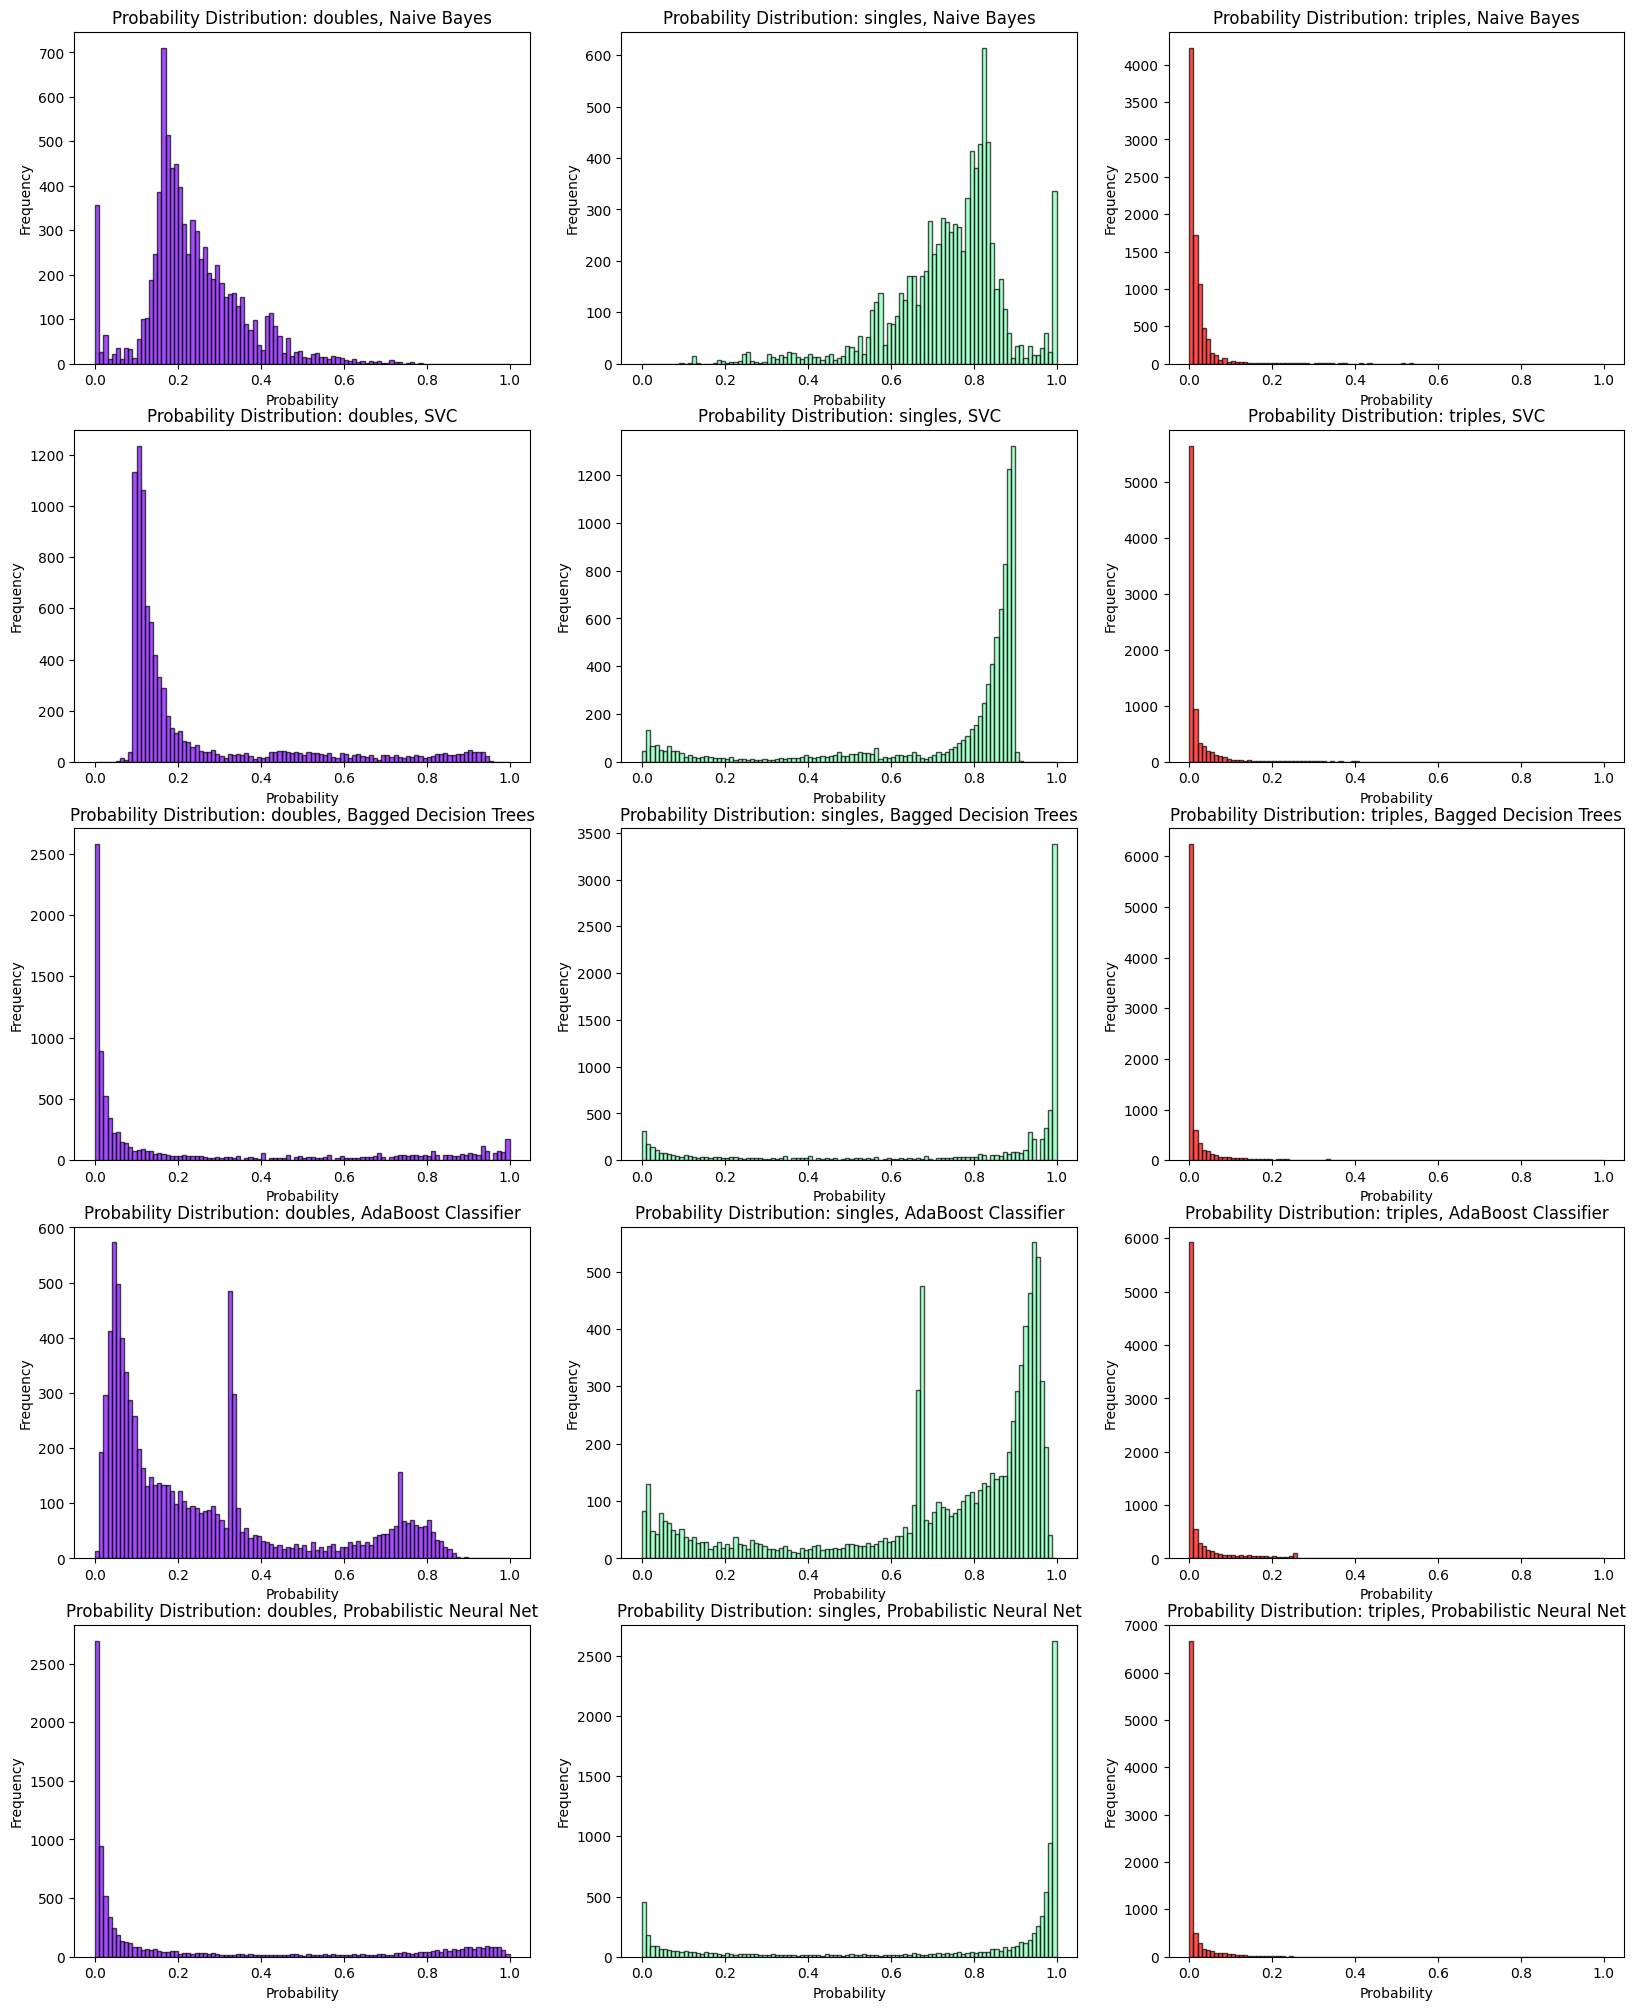

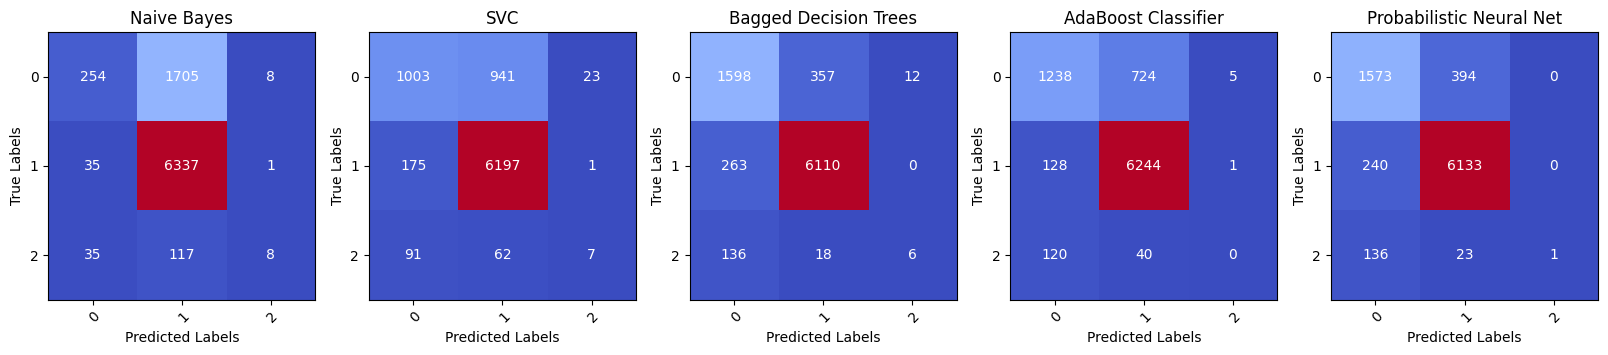

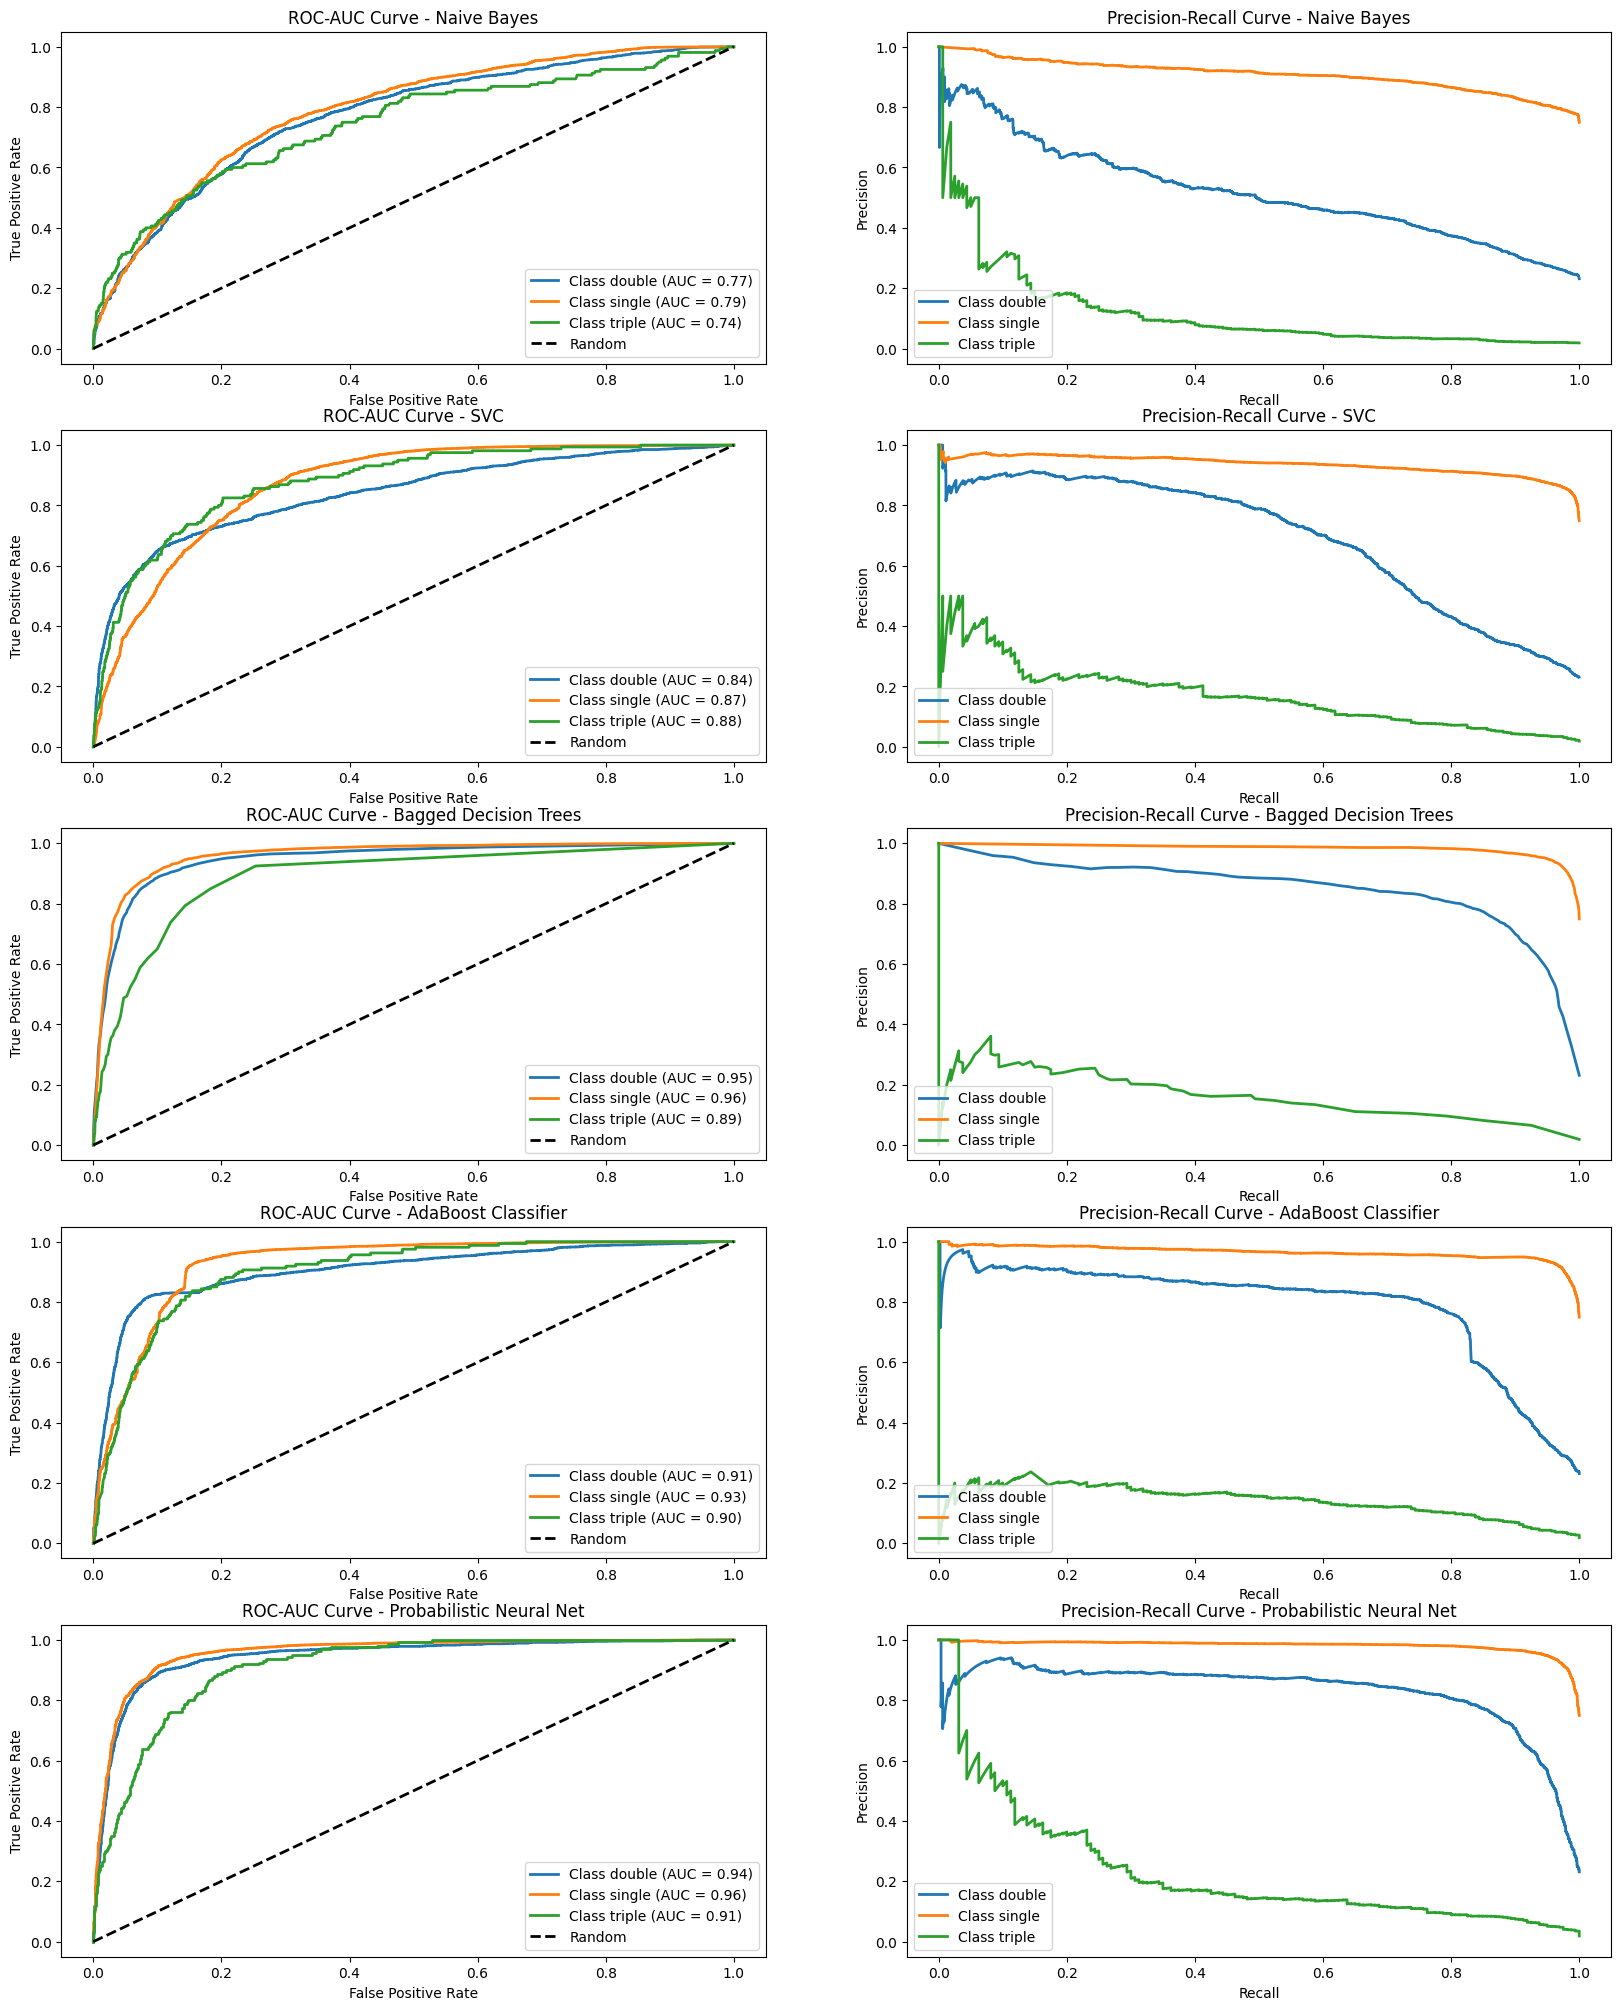

In [17]:
# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'distance','sprint_speed']
categorical_features = ['home_team']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)


# Define the classifiers
classifiers = [
    ('Naive Bayes', CalibratedClassifierCV(GaussianNB(), cv=3, method='isotonic')),
    ('SVC', CalibratedClassifierCV(SVC(probability=True, class_weight = 'balanced'), cv=3, method='isotonic')),
    ('Bagged Decision Trees', BaggingClassifier(n_estimators=100)),
    ('AdaBoost Classifier', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=5, method = 'isotonic')),
    ('Probabilistic Neural Net', None)
]

# Define the metrics
metrics = {
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC-AUC': roc_auc_score,
    "Cohen's Kappa": cohen_kappa_score,
    'Recall, double': None,
    'Recall, single': None,
    'Recall, triple': None
}

# Create an empty DataFrame to store the metrics
results_df = pd.DataFrame(columns=list(metrics.keys()))

classes = np.unique(y_train)
num_classifiers = len(classifiers)


# Create a figure to hold the confusion matrices and ROC-AUC, Precision-Recall Curves
fig, axes = plt.subplots(nrows= num_classifiers, ncols=3, figsize=(20, 5 * num_classifiers))
fig2, axes2 = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(20, 5 * num_classifiers))
fig3, axes3 = plt.subplots(nrows= num_classifiers, ncols=2, figsize=(20, 5 * num_classifiers))

# Iterate over classifiers
for z, (name, classifier) in enumerate(classifiers):
    print('Evaluating...', name)


    if name == "Probabilistic Neural Net":
      X_train = pipeline.named_steps['preprocessor'].fit_transform(X_train)

      classifier = tf.keras.models.Sequential([tf.keras.layers.Dense(35, activation='relu',input_shape=(X_train.shape[1],)), tf.keras.layers.Dense(3, activation='softmax')])

      # Create the pipeline
      pipeline = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('classifier', classifier)
      ])


      model = pipeline.named_steps['classifier']

      # Compile the model
      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

      model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

      X_test= pipeline.named_steps['preprocessor'].transform(X_test)

      # Convert test data to the appropriate data type
      X_test = X_test.astype(np.float32)

      # Predict probability distributions for the test set
      y_pred_proba = model.predict(X_test)

      # Convert predicted probabilities to class labels
      y_pred = tf.argmax(y_pred_proba, axis=1)

      # Convert one-hot encoded test labels back to original labels
      #y_test_labels = tf.argmax(y_test, axis=1)

    else:
      # Create the pipeline
      pipeline = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('classifier', classifier)
      ])

      # Train the pipeline
      pipeline.fit(X_train, y_train)

      # Make predictions on the test set
      y_pred = pipeline.predict(X_test)
      y_pred_proba = pipeline.predict_proba(X_test)





    # Plot Probability Distribution For Each Class For Each Classifier
    ax_prob = axes
    plot_probability_histograms(name, y_pred_proba, ax_prob, z)


    # Calculate and store the metrics for the classifier
    results = {key: None for key in metrics.keys()}

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)


    # Iterate over the list and find the index of the tuple containing the model name
    ax_index = None
    for i, item in enumerate(classifiers):
        if name in item:
            ax_index = i
            break

    # Plot confusion matrix
    ax_cm = axes2[ax_index]
    plot_confusion_matrix(cm, ax_cm, name, classes)


    # Define each row of matplotlib figure, plot ROC-AUC and Precision-Recall
    ax_rocauc = axes3[z, 0]
    ax_pr = axes3[z, 1]

    plot_rocauc_pr_rec(name, ax_rocauc, ax_pr, y_test ,y_pred_proba, classes)

    # Add all metrics to dictionary, add to DataFrame
    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1-Score']:
            metric_value = metric_func(y_test, y_pred, average='weighted')
        elif metric_name == 'ROC-AUC':
          metric_value = metric_func(y_test, y_pred_proba, average = 'weighted', multi_class = 'ovr')
        elif metric_name == "Cohen's Kappa":
          metric_value = metric_func(y_test, y_pred)

        results[metric_name] = metric_value

    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract precision values from the report
    class_names = list(report.keys())
    class_names.remove('accuracy') # Remove 'accuracy' from class names
    class_names.remove('macro avg') # Remove 'macro avg' from class names
    class_names.remove('weighted avg') # Remove 'weighted avg' from class names

    for class_name in class_names:
      results[f'Recall, {label_encoder.inverse_transform([int(class_name)])[0]}'] = report[class_name]['recall']

    #print(results)

    # Add the results to the DataFrame
    results_df.loc[name] = pd.Series(results)

In [18]:
# Print the results
results_df

,Precision,Recall,F1-Score,ROC-AUC,Cohen's Kappa,"Recall, double","Recall, single","Recall, triple"
Naive Bayes,0.772607,0.776353,0.706917,0.783875,0.176119,0.129131,0.994351,0.05000
SVC,0.832473,0.847882,0.829470,0.861204,0.539440,0.509914,0.972383,0.04375
Bagged Decision Trees,0.897859,0.907529,0.900408,0.955365,0.752465,0.812405,0.958732,0.03750
AdaBoost Classifier,0.860818,0.880235,0.865664,0.921104,0.649166,0.629385,0.979758,0.00000
Probabilistic Neural Net,0.907623,0.906706,0.897790,0.953646,0.747291,0.799695,0.962341,0.00625
